In [3]:
#!pip install deepxde
%matplotlib inline

Convection-diffusion problems in fluid dynamics involve the transport of scalar quantities such as temperature, concentration, or density, within a moving fluid. These phenomena are described by a partial differential equation that combines the effects of convection and diffusion.

The convection-diffusion equation for a scalar $\phi$ in a 1D incompressible fluid is given by:

\begin{equation}
    \frac{\partial \phi}{\partial t} + u\frac{\partial \phi}{\partial x} = D\frac{\partial^2 \phi}{\partial x^2}
\end{equation}

Here, $u$ is the fluid velocity in the $x$ direction, $D$ is the diffusion coefficient, and $\frac{\partial}{\partial x}$ denotes the partial derivative with respect to $x$. The first part of the equation represents convection, describing how the scalar quantity is transported by the fluid's motion. The second part represents diffusion, describing how the scalar quantity is spread due to concentration or temperature gradients.

**Initial Condition**

At the initial time, the solution to the equation is a Gaussian function:

\begin{equation}
    \phi (x, 0) = A e^{-(\frac{x}{\sigma})^2}
\end{equation}

The parameters of the Gaussian function are $A = 1$ and $\sigma = 0.05$.

**Boundary Conditions**

**Left (Dirichlet):**  $\phi (x=0, t) = f(t) $

**Right (Neumann):**  $ \frac{\partial \phi ( x = 1, t) }{\partial x}  = 0 $

**Reference Solution**

\begin{equation}
    \phi (x, t) = A \left ( \sqrt{\frac{\pi \sigma ^2}{\pi (\sigma^2 + 4 \nu t)}}   e^{\left( \frac{-(x-ct)^2}{\sigma ^2 + 4 \nu t} \right) } \right)
\end{equation}

The above is the reference solution to the convection-diffusion problem under the given conditions.

In [4]:
# Importing required libraries
import deepxde as dde
import numpy as np
import math
from deepxde.backend import tf
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [5]:
# Defining initial parameters
xmin, tmin = 0, 0
xmax, tmax = 1, 1
c = 1
nu = 0.01
sigma = 0.05
A = 1
k = c
# Defining the geometry of the problem: spatial and temporal domains
geom = dde.geometry.Interval(xmin, xmax)
timedomain = dde.geometry.TimeDomain(tmin, tmax)
geotime = dde.geometry.GeometryXTime(geom, timedomain)

In [6]:
# Problem (PDE) definition
def pde(x, u):
    """
    Definition of the PDE

    Args:
    x (Tensor): A tensor of shape (batch_size, dim) containing the input features.
    u (Tensor): A tensor of shape (batch_size, 1) containing the target variable.

    Returns:
    Tensor: the result of the PDE operation.
    """
    du_t = dde.grad.jacobian(u, x, i=0, j=1)
    du_x = dde.grad.jacobian(u, x, i=0, j=0)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    return (du_t- nu*du_xx + c*du_x)

In [7]:
# Analytical solution
def func_sol(x):
    """
    Function definition for analytic solution

    Args:
    x (Tensor): A tensor containing the input features.

    Returns:
    Tensor: the result of the operation.
    """
    c = 1.0
    nu = 0.01
    sigma = 0.05
    A = 1.0
    return A * np.sqrt((sigma**2 * np.pi) / (np.pi * (sigma**2 + 4 * nu * x[:, 1:]))) * np.exp(-(x[:, 0:1] - c * x[:, 1:])**2 / (sigma**2 + 4 * nu * x[:, 1:]))


def boundary_left(x, on_boundary):
    """
    Function for defining left boundary condition

    Args:
    x (Tensor): A tensor containing the input features.
    on_boundary (bool): Boolean indicating if the current point is on the boundary.

    Returns:
    bool: True if on the left boundary, False otherwise.
    """
    return on_boundary and np.isclose(x[0], 0)


def boundary_right(x, on_boundary):
    """
    Function for defining right boundary condition

    Args:
    x (Tensor): A tensor containing the input features.
    on_boundary (bool): Boolean indicating if the current point is on the boundary.

    Returns:
    bool: True if on the right boundary, False otherwise.
    """
    return on_boundary and np.isclose(x[0], 1)

# Applying boundary conditions
BC_left = dde.DirichletBC(geotime, func_sol, boundary_left)
BC_right = dde.NeumannBC(geotime, lambda x: 0, boundary_right)
IC = dde.IC(geotime, func_sol, lambda _, on_initial:on_initial)

In [8]:
# Defining the training data
data = dde.data.TimePDE(geotime, pde, [BC_left, BC_right, IC], num_domain=4000, num_boundary = 4000, num_test=8000, num_initial=4000, solution=func_sol)

In [9]:
# Defining the architecture of the neural network
layer_size = [2] + [64]*3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"

net = dde.nn.FNN(layer_size, activation, initializer)
model = dde.Model(data, net)
model.compile("adam", lr=0.0001, metrics = ["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.071999 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.680075 s



In [10]:
# Train model for 50000 iterations and keep track of loss history
loss_history, train_state = model.train(iterations=10000)

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [3.60e-02, 7.93e-02, 2.69e-02, 4.42e-02]    [3.25e-02, 7.93e-02, 2.69e-02, 4.42e-02]    [1.52e+00]    
1000      [7.45e-04, 2.52e-02, 4.11e-05, 2.87e-02]    [4.33e-04, 2.52e-02, 4.11e-05, 2.87e-02]    [9.06e-01]    
2000      [1.16e-03, 2.26e-02, 5.75e-04, 2.66e-02]    [5.87e-04, 2.26e-02, 5.75e-04, 2.66e-02]    [8.43e-01]    
3000      [1.98e-03, 1.75e-02, 2.59e-04, 2.14e-02]    [3.09e-03, 1.75e-02, 2.59e-04, 2.14e-02]    [7.31e-01]    
4000      [5.86e-03, 6.06e-03, 2.99e-04, 9.08e-03]    [1.01e-02, 6.06e-03, 2.99e-04, 9.08e-03]    [4.70e-01]    
5000      [4.94e-03, 2.22e-03, 2.03e-04, 4.49e-03]    [1.03e-02, 2.22e-03, 2.03e-04, 4.49e-03]    [3.71e-01]    
6000      [4.18e-03, 8.01e-04, 1.89e-04, 2.12e-03]    [9.54e-03, 8.01e-04, 1.89e-04, 2.12e-03]    [3.25e-01]    
7000      [3.75e-03, 4.33e-04, 1.54e-04, 1.22e-03]    [9.02e-03, 4.33e-04, 1.

In [11]:
# Plotting the results
x_data = np.linspace(xmin, xmax, num=1000)
t_data = np.linspace(tmin, tmax, num = 1000)
test_t, test_x = np.meshgrid(t_data, x_data)
test_domain = np.vstack((np.ravel(test_t), np.ravel(test_x))).T
predicted_solution = model.predict(test_domain)
residual = model.predict(test_domain, operator=pde)

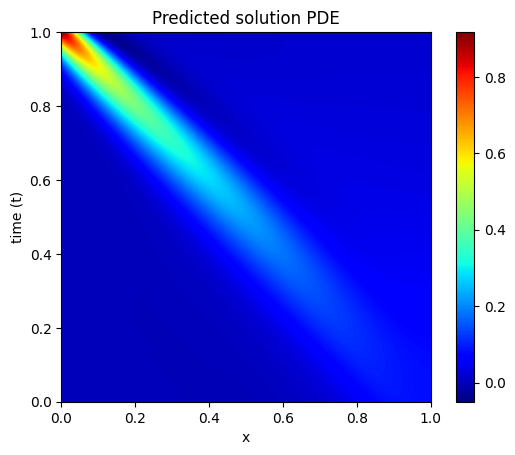

In [12]:
extend = xmin, xmax, tmin, tmax
plt.imshow(predicted_solution.reshape((1000, 1000)), cmap="jet", extent = extend)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("time (t)")
plt.title("Predicted solution PDE")
plt.savefig("Predicted_1.png")

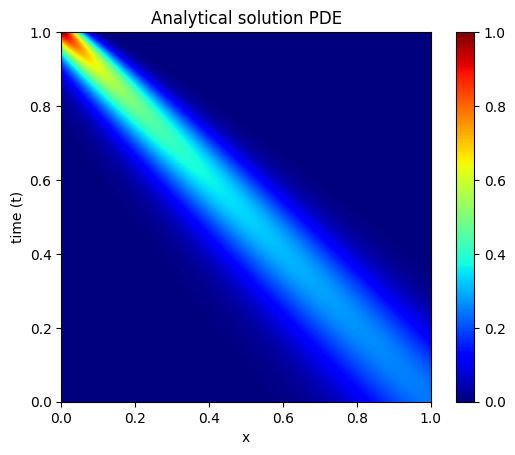

In [13]:
plt.imshow(func_sol(test_domain).reshape((1000, 1000)), cmap="jet", extent = extend)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("time (t)")
plt.title("Analytical solution PDE")
plt.savefig("solution.png")

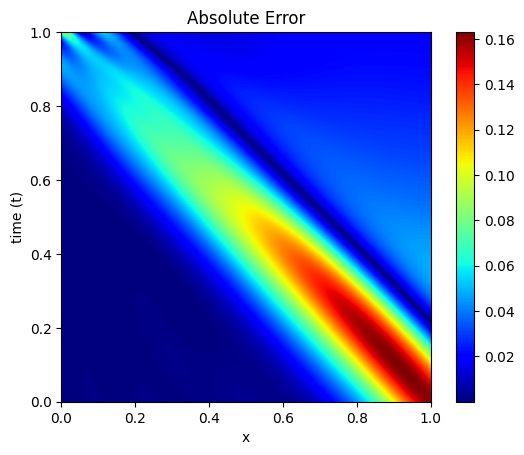

In [14]:
plt.imshow((abs(predicted_solution-func_sol(test_domain))).reshape((1000, 1000)), cmap="jet", extent = extend)
plt.colorbar()
plt.xlabel("x")
plt.ylabel("time (t)")
plt.title("Absolute Error")
plt.savefig("Residuals_1.png")

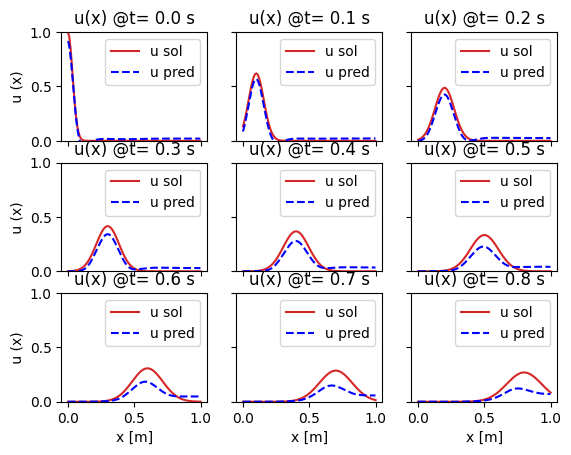

In [24]:
t_long = np.arange(tmin, tmax, 0.1)
x_long = np.arange(xmin, xmax, 0.001)

def solution_pde(t):
    c = 1.0
    nu = 0.01
    sigma = 0.05
    A = 1.0
    x = np.linspace(0, 1, 100)
    x, t = np.meshgrid(x, t)
    u = A * np.sqrt((sigma**2 * np.pi) / (np.pi * (sigma**2 + 4 * nu * t))) * np.exp(-(x - c * t)**2 / (sigma**2 + 4 * nu * t))
    return x,u

sol_x, sol_u = zip(*[solution_pde(t) for t in np.arange(0, 1.0, 0.1)])

t_domain = [np.vstack((np.ravel(np.meshgrid(x_long, t_long[c])[0]), np.ravel(np.meshgrid(x_long, t_long[c])[1]))).T for c in range(len(t_long))]
y_x = [model.predict(domain) for domain in t_domain]

fig, axs = plt.subplots(3, 3)

for i in range(3):
    for j in range(3):
        idx = 3*i + j
        if idx < len(t_long):
            axs[i, j].plot(sol_x[idx].T, sol_u[idx].T, 'tab:red')
            axs[i, j].plot(x_long, y_x[idx], '--b')
            axs[i, j].set_title('u(x) @t= {} s'.format(idx/10))
            axs[i, j].set_ylim(0, 1)
            axs[i, j].legend(['u sol', "u pred"])
            axs[i, j].set(xlabel='x [m]', ylabel=' u (x) ')
            axs[i, j].label_outer()

plt.show()

In [16]:
#dde.saveplot(loss_history, train_state, issave=True, isplot=True)

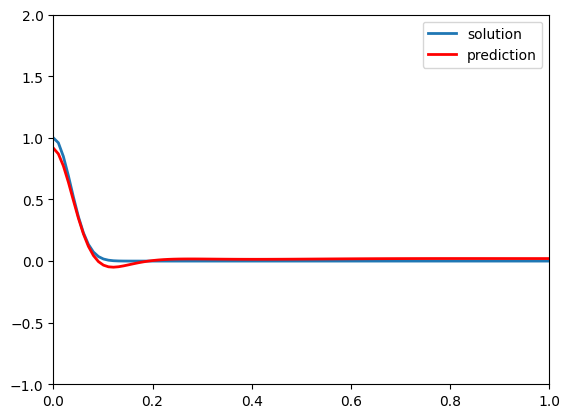

In [25]:
# Input Data
t = np.linspace(0, 1, 100)
x = np.linspace(0, 1, 100)

# Time- and x-dependent output function
def output(t):
    # Boundary limits a = 0.3 # Alpha diffusion coefficient
    c = 1
    nu = 0.01
    sigma = 0.05
    A = 1.0
    x = np.linspace(0, 1, 100)
    # Analytic Solution
    x, t = np.meshgrid(x, t)
    u = A * np.sqrt((sigma**2 * np.pi) / (np.pi * (sigma**2 + 4 * nu * t))) * np.exp(-(x - c * t)**2 / (sigma**2 + 4 * nu * t))
    return u
def prediction_sol(x,t):
    t_x1, t_t1 = np.meshgrid(x, t)
    t_domain1 = np.vstack((np.ravel(t_x1), np.ravel(t_t1))).T
    y = model.predict(t_domain1)
    return y
# Figure initialization
fig, ax = plt.subplots()
ax.set_xlim(0, 1)
ax.set_ylim(-1, 2)
txt_title = ax.set_title('')
line, = ax.plot([], [], lw=2)
line2, = ax.plot([], [], 'r', lw=2)

# Animation update function
def update(frame):
    line.set_data(x, output(t[frame]))
    line2.set_data(x, prediction_sol(x,t[frame]))
    return line, line2

# Animation
ani = FuncAnimation(fig, update, frames=len(t), interval=400, blit=True)
ax.legend(['solution', "prediction"]);

In [26]:
from IPython.display import HTML
HTML(ani.to_jshtml())